In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle as pkl
from scipy import stats

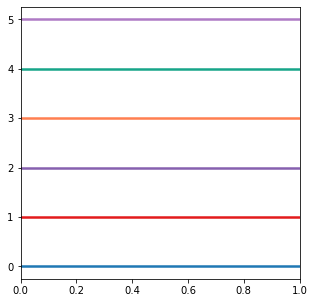

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

new_cmap = [ '#1F78B4', '#E31A1C', '#8660AF', '#FF7F50', '#17A589', '#AF7AC5']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,6))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [3]:
MATH_type='MATHfree'
oligomersizes = np.arange(2, 61, 2)
calcpath = f'calc_data_{MATH_type}'
concs = [5.0, 10.0, 20.0, 30.0, 40.0]

In [4]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

In [5]:
#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

In [6]:
#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

In [7]:
#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

In [8]:
#Calculate concentrations with isodesmic model
#Returns array of oligomer concentrations
def isodesmic(Ka, Ctot, oligomersizes):
    
    BTBdimer_conc = Ctot/2.0

    C = []
    
    #Calculate monomer concentration
    conc = (2*BTBdimer_conc*Ka+1-np.sqrt(4*BTBdimer_conc*Ka+1))/(2*BTBdimer_conc*(Ka**2))
    C.append(conc)
    
    #Calculate oligomer concentrations
    for i in range(1,len(oligomersizes)):
        conc = Ka*C[i-1]*C[0]
        C.append(conc)
        
    return np.array(C)

In [9]:
def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

# Fit Kd starting structures SAXS

In [10]:
#Kd values to scan
Kd_scan = np.logspace(-2, 2, num=10000) #Make sure this range is fine enough

In [11]:
calc_data = []
for size in oligomersizes:
    I_calc = np.genfromtxt(f'calc_data_startstructure/SAXS_startstructure_{size}mer.fit', usecols=(3), skip_header=6)
    calc_data.append(I_calc)
calc_data = np.array(calc_data)

print(calc_data.shape)

#Get experimental SAXS
Iexp_vs_concs = []
err_exp_vs_concs = []
for conc in concs:
    exp_file = f'WT_{MATH_type}_scaleoffsetonly/exp_data_{conc}uM.dat'
    q, Iexp, err_exp = load_exp_SAXS(exp_file)
    Iexp_vs_concs.append(Iexp)
    err_exp_vs_concs.append(err_exp)

chi2_global_vs_iterations = []
Ka_fitted_vs_iterations = []

#Scan Kd values for given set of single structures
chi2_global_vs_Kd_scan = []
for Kd in Kd_scan: 
    Ka = 1/Kd

    chi2_global = 0
    for i,conc in enumerate(concs):

        #Get concentrations from isodesmic model
        isodesmic_concs = isodesmic(Ka, conc, oligomersizes)
        volume_weights = isodesmic_concs*oligomersizes
        volume_weights = volume_weights/np.sum(volume_weights)

        #Calculate average SAXS
        Iaverage = np.sum(calc_data*volume_weights[:,np.newaxis],axis=0)

        #Fit SAXS scale and cst
        Iaverage_fit, slope, intercept, r_value = fit_scale_offset(Iaverage, Iexp_vs_concs[i], err_exp_vs_concs[i])

        #Calculate chi2 and add to running sum
        chi2 = get_chi2(Iaverage_fit, Iexp_vs_concs[i], err_exp_vs_concs[i])
        chi2_global += chi2

    #Average global chi2 and append
    chi2_global /= len(concs)
    chi2_global_vs_Kd_scan.append(chi2_global)
    
chi2_global_vs_Kd_scan = np.array(chi2_global_vs_Kd_scan)
    
#Select best fit Kd and corresponding chi2
min_index = np.argmin(chi2_global_vs_Kd_scan)
Kd_fitted = Kd_scan[min_index]
Ka_fitted = 1/Kd_fitted
chi2_min = chi2_global_vs_Kd_scan[min_index]

chi2_starting_structures = chi2_min

(30, 131)


In [12]:
print(1/Ka_fitted)
print(chi2_starting_structures)

0.4287096075428158
4.034924235013634


# Plot

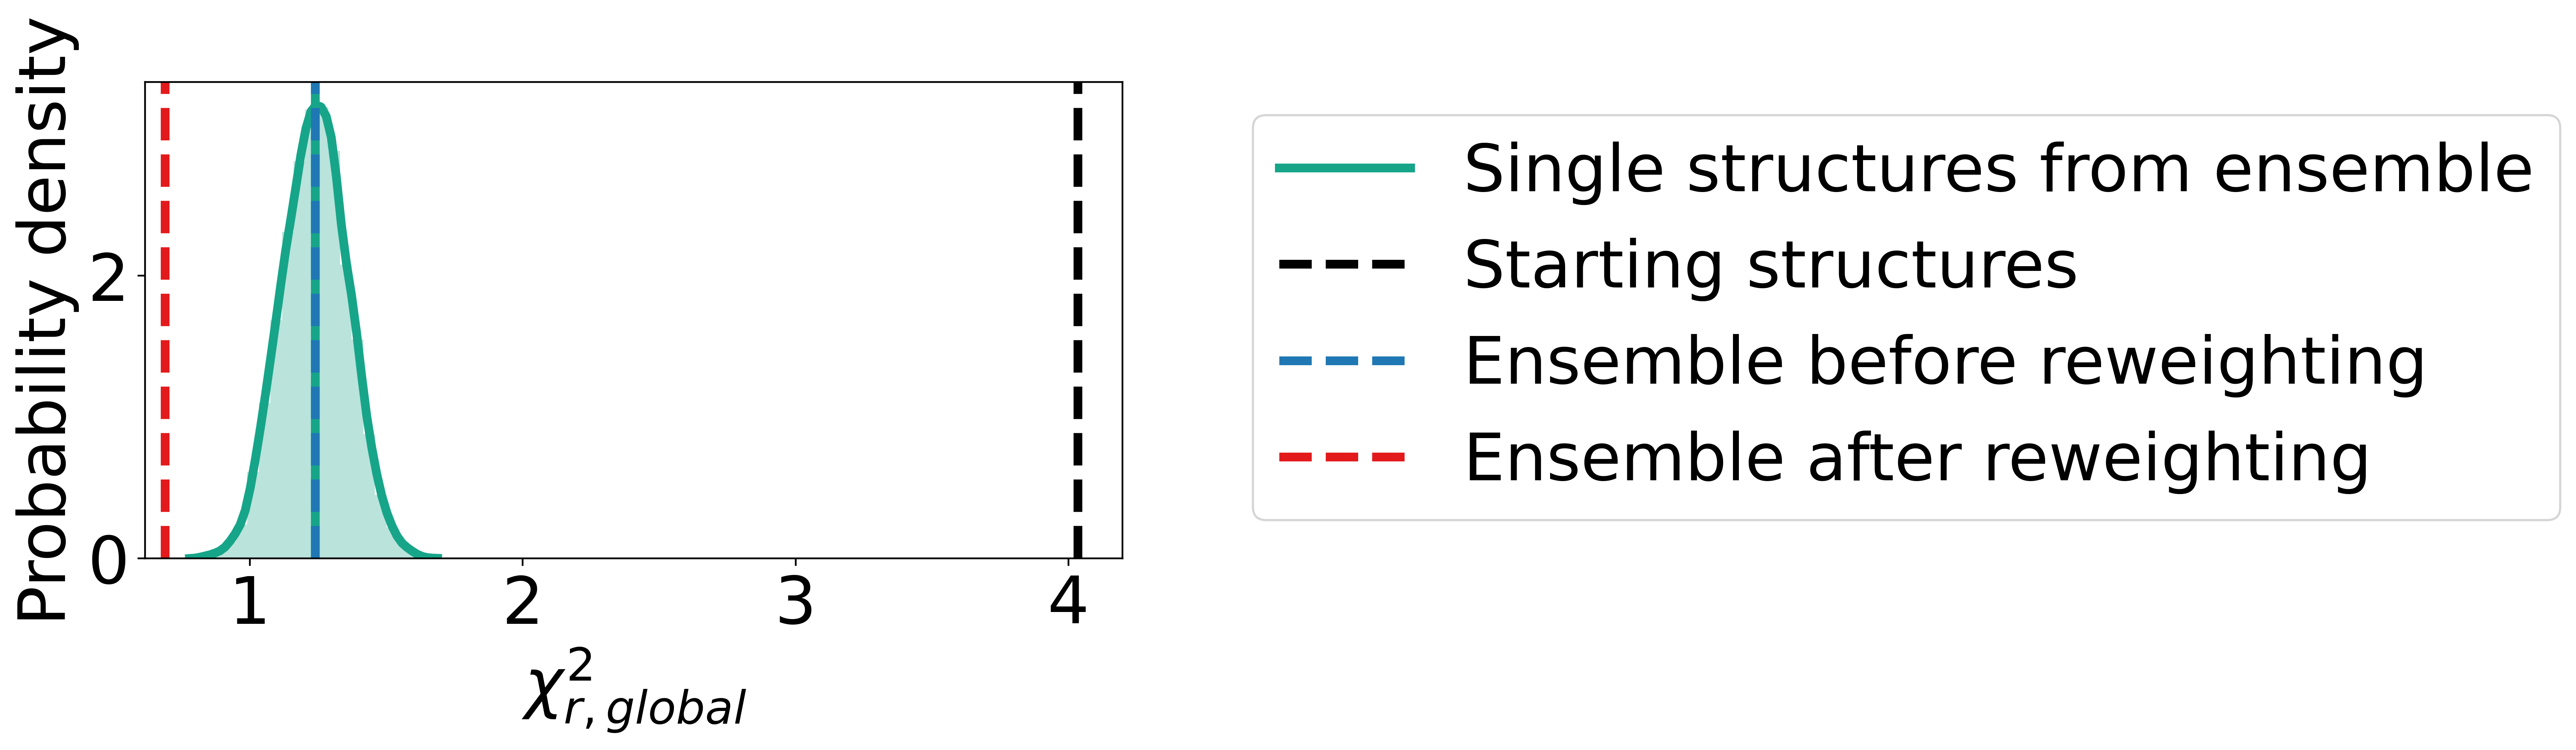

In [13]:
scan_singlestructure_results_MATHfree = load_pickle(f'pickles/scan_singlestructure_results_MATHfree_fitKa.pkl')

chi2_global_vs_iterations_MATHfree = scan_singlestructure_results_MATHfree['chi2']
#chi2_global_vs_iterations_MATHfixed = scan_singlestructure_results_MATHfixed['chi2']

#Start plot
fig = plt.figure(figsize=(8,4), dpi=400)
plt.xlabel('$\chi^2_{r,global}$', fontsize=30)
plt.ylabel('Probability density', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#KDE
kde_x = np.linspace( np.amin(chi2_global_vs_iterations_MATHfree)*0.95, np.amax(chi2_global_vs_iterations_MATHfree)*1.01, num = 50 )
kde_y = stats.gaussian_kde(chi2_global_vs_iterations_MATHfree, bw_method = "silverman").evaluate(kde_x)

#Plot
plt.hist(chi2_global_vs_iterations_MATHfree, density=True, alpha=0.3, bins=20, color=colors[4])
plt.plot(kde_x, kde_y, '-', linewidth=4, color=colors[4])
plt.axvline(np.average(chi2_global_vs_iterations_MATHfree),linewidth=4, alpha=1, color=colors[4], label='Single structures from ensemble')

plt.axvline(chi2_starting_structures, ls='--', linewidth=4, alpha=1, color='black', label='Starting structures')
plt.axvline(1.24, ls='--', linewidth=4, alpha=1, color=colors[0], label='Ensemble before reweighting')
plt.axvline(0.69, ls='--', linewidth=4, alpha=1, color=colors[1], label='Ensemble after reweighting')

#Legend
plt.legend(fontsize=30, ncol=1, bbox_to_anchor=(1.10, 1.0))

#Save
fig.savefig(f"plots/scan_singlestructures_chi2_MATHfree_fitKa.pdf", bbox_inches='tight', pad_inches=1)
fig.savefig(f"plots/scan_singlestructures_chi2_MATHfree_fitKa.png", bbox_inches='tight', pad_inches=1)